In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
from torch import logsumexp
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 64
STEPS = 10
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS_GLOBAL = D + K
NUM_OBS_LOCAL = D + K*D + K*D
BATCH_SIZE = 100
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
CUDA = False

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs_true = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
mus_true = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
sigma2_true = torch.from_numpy(np.load('gmm_dataset/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
num_seqs = Xs.shape[0]

In [4]:
class Encoder_global(nn.Module):
    def __init__(self, num_obs=NUM_OBS_GLOBAL,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_stats))
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
        self.enc_hidden2 = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.mus_mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        hidden = self.enc_hidden(stats)
        q_alpha = torch.exp(self.sigmas_log_alpha(hidden)).view(-1, K, D) ## B * K * D
        q_beta = torch.exp(self.sigmas_log_beta(hidden)).view(-1, K, D) ## B * K * D
        precisions = Gamma(q_alpha, q_beta).sample((num_samples,)) ## S * B * K * D
        
        hidden2 = self.enc_hidden2(stats)                 
        q_mean = self.mus_mean(hidden2).view(-1, K, D).unsqueeze(0).repeat(num_samples, 1, 1, 1)
        q_nu = torch.exp(self.mus_log_nu(hidden2).view(-1, K, D))
        q_sigma = torch.sqrt(1. / (q_nu.unsqueeze(0).repeat(num_samples, 1, 1, 1) * precisions))
        mus = Normal(q_mean, q_sigma).sample()  
        return q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions ## mus_mean and mus_sigma are S * B * K * D
    
class Encoder_local(nn.Module):
    def __init__(self, num_obs=NUM_OBS_LOCAL,
                       num_hidden=NUM_HIDDEN,
                       num_latents=K):
        super(self.__class__, self).__init__()
        self.enc_onehot = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_latents),
            nn.Softmax(-1))
        
    def forward(self, obs, N, K, D, num_samples, batch_size):
        zs_pi = self.enc_onehot(obs).view(batch_size, N, K)
        zs = cat(zs_pi).sample((num_samples,))
        log_qz = cat(zs_pi).log_prob(zs).view(num_samples, batch_size, -1).sum(-1) ## S * B
        zs = zs.view(num_samples, batch_size, -1, K) ## S * B * N * K
        return zs_pi, zs, log_qz

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-2)
        
        
def initialize():
    enc_global = Encoder_global()
    enc_local = Encoder_local()
    enc_global.apply(weights_init)

    optimizer =  torch.optim.Adam(list(enc_global.parameters()) + list(enc_local.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_global, enc_local, optimizer
enc_global, enc_local, optimizer = initialize()


# def kl_normal_normal(p_mean, p_std, q_mean, q_std):
#     var_ratio = (p_std / q_std).pow(2)
#     t1 = ((p_mean - q_mean) / q_std).pow(2)
#     return 0.5 * (var_ratio + t1 - 1 - var_ratio.log())

# def kls_gaussians(mus_mean, mus_sigma, posterior_mean, posterior_sigma):
#     Kl_exclusive = kl_normal_normal(mus_mean, mus_sigma, posterior_mean, posterior_sigma).sum(-1).sum(-1).mean()
#     Kl_inclusive = kl_normal_normal(posterior_mean, posterior_sigma, mus_mean, mus_sigma).sum(-1).sum(-1).mean()
#     return Kl_exclusive, Kl_inclusive

# def kl_gamma_gamma(p_alpha, p_beta, q_alpha, q_beta):
#     t1 = q_alpha * (p_beta / q_beta).log()
#     t2 = torch.lgamma(q_alpha) - torch.lgamma(p_alpha)
#     t3 = (p_alpha - q_alpha) * torch.digamma(p_alpha)
#     t4 = (q_beta - p_beta) * (p_alpha / p_beta)
#     return t1 + t2 + t3 + t4

# def kls_gammas(precsions_alpha, precisions_beta, posterior_alpha, posterior_beta):
#     KL_exclusive = kl_gamma_gamma(precsions_alpha, precisions_beta, posterior_alpha, posterior_beta).sum(-1).sum(-1).mean()
#     KL_inclusive = kl_gamma_gamma(posterior_alpha, posterior_beta, precsions_alpha, precisions_beta).sum(-1).sum(-1).mean()
#     return KL_exclusive, KL_inclusive

In [6]:
prior_mean = torch.zeros((BATCH_SIZE, K, D))
prior_nu = torch.ones((BATCH_SIZE, K, D))
prior_alpha = torch.ones((BATCH_SIZE, K, D)) * 2.0
prior_beta = torch.ones((BATCH_SIZE, K, D)) * 2.0

def log_joints_gmm(X, Z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size):
    log_probs = torch.zeros(batch_size).float()
    ## priors on mus and sigmas size B
    log_probs = log_probs + Gamma(prior_alpha, prior_beta).log_prob(precisions).sum(-1).sum(-1)
    prior_sigma = 1. / torch.sqrt(prior_nu * precisions)
    log_probs = log_probs + Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1)
    ## Z B-by-T-by-K
    log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1)
    labels = Z.nonzero()
    sigmas = 1. / torch.sqrt(precisions)
    log_probs = log_probs + Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), 
                                   sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(X).sum(-1).sum(-1)
    return log_probs

def inti_global(K, D, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size):
    precisions = Gamma(prior_alpha, prior_beta).sample()
    prior_sigma = 1. / torch.sqrt(prior_nu * precisions)
    mus = Normal(prior_mean, prior_sigma).sample()
    ## log prior size B
    log_p =  Normal(prior_mean, prior_sigma).log_prob(mus).sum(-1).sum(-1) + Gamma(prior_alpha, prior_beta).log_prob(precisions).sum(-1).sum(-1)
    return mus, precisions, log_p

def E_step(X, mus, precisions, N, D, K, batch_size):
    mus_flat = mus.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
    sigma = 1. / torch.sqrt(precisions)
    sigma_flat = sigma.view(-1, K*D).unsqueeze(1).repeat(1, N, 1)
    data = torch.cat((X, mus_flat, sigma_flat), -1).view(batch_size*N, -1)
    zs_pi, zs, log_q_z = enc_local(data, N, K, D, 1, batch_size)
    return zs_pi, zs[0], log_q_z[0]

def M_step(X, z, N, D, K, batch_size):
    data = torch.cat((X, z), dim=-1).view(batch_size*N, -1)
    q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions = enc_global(data, K, D, 1, batch_size)  
    log_q_eta =  Normal(q_mean[0], q_sigma[0]).log_prob(mus[0]).sum(-1).sum(-1) + Gamma(q_alpha, q_beta).log_prob(precisions[0]).sum(-1).sum(-1)## B
    return q_mean[0], q_nu, q_alpha, q_beta, q_sigma[0], mus[0], precisions[0], log_q_eta

def conjugate_posterior(Xs, Zs, prior_mean, prior_nu, prior_alpha, prior_beta, N, K, D, batch_size):
    stat1 = Zs.sum(1).unsqueeze(-1).repeat(1, 1, D) ## B * K * D
    xz_nk = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), Xs.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)) # B*N*K*D
    stat2 = xz_nk.sum(1) ## B*K*D
    stat3 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), torch.mul(Xs, Xs).unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    
    x_bar = stat2 / stat1
    posterior_beta = prior_beta + (stat3 - (stat2 ** 2) / stat1) / 2. + (stat1 * prior_nu / (stat1 + prior_nu)) * ((prior_nu**2) + x_bar**2 - 2 * x_bar *  prior_nu) / 2.
    posterior_nu = prior_nu + stat1
    posterior_mean = (prior_mean * prior_nu + stat2) / (prior_nu + stat1) 
    posterior_alpha = prior_alpha + (stat1 / 2.)
#     posterior_sigma = torch.sqrt(posterior_nu * (posterior_beta / posterior_alpha))
    return posterior_mean, posterior_nu, posterior_alpha, posterior_beta


def kl_NG_NG(p_mean, p_nu, p_alpha, p_beta, q_mean, q_nu, q_alpha, q_beta):
    diff = q_mean - p_mean
    t1 = (1. / 2) * ((p_alpha / p_beta) *  (diff ** 2) * q_nu + (q_nu / p_nu) - (torch.log(q_nu) - torch.log(p_nu)) - 1)
    t2 = q_alpha * (torch.log(p_beta) - torch.log(q_beta)) - (torch.lgamma(p_alpha) - torch.lgamma(q_alpha)) 
    t3 = (p_alpha - q_alpha) * torch.digamma(p_alpha) - (p_beta - q_beta) * p_alpha / p_beta
    return t1 + t2 + t3

def kls_NGs(p_mean, p_nu, p_alpha, p_beta, q_mean, q_nu, q_alpha, q_beta):
    kl_exclusive = kl_NG_NG(q_mean, q_nu, q_alpha, q_beta, p_mean, p_nu, p_alpha, p_beta).sum(-1).sum(-1).mean()
    kl_inclusive = kl_NG_NG(p_mean, p_nu, p_alpha, p_beta, q_mean, q_nu, q_alpha, q_beta).sum(-1).sum(-1).mean()
    return kl_exclusive, kl_inclusive
    
def rws(Xs, Pi, Zs_true, mus_true, sigma2_true, N, K, D, num_samples, steps, batch_size):
    """
    train both encoders
    rws gradient estimator
    sis sampling scheme
    no resampling
    """
    posterior_mean, posterior_nu, posterior_alpha, posterior_beta = conjugate_posterior(Xs, Zs_true, prior_mean, prior_nu, prior_alpha, prior_beta, N, K, D, batch_size)
    log_increment_weights = torch.zeros((steps, num_samples, batch_size))
    Z_samples = torch.zeros((num_samples, batch_size, N, K))
    for m in range(steps):
        if m == 0:
            for l in range(num_samples):
                mus, precisions, log_p_eta = inti_global(K, D, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                zs_pi, z, log_q_z = E_step(Xs, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                labels = z.nonzero()
                log_p_z = cat(Pi).log_prob(z).sum(-1)
                sigmas = 1. / torch.sqrt(precisions)
                log_p_x = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(Xs).sum(-1).sum(-1)
                log_increment_weights[m, l] = log_p_x + log_p_z - log_q_z     
        else:
            for l in range(num_samples):
                z_prev = Z_samples[l]
                q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(Xs, z_prev, N, D, K, batch_size)
                zs_pi, z, log_q_z = E_step(Xs, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                log_p_joint = log_joints_gmm(Xs, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                log_increment_weights[m, l] = log_p_joint - log_q_z - log_q_eta

    increment_weights = torch.exp(log_increment_weights - logsumexp(log_increment_weights, 1).unsqueeze(1).repeat(1, num_samples, 1)).detach()
    ess = (1./ (increment_weights ** 2).sum(1)).mean(0).mean()
    
    euboall = torch.mul(increment_weights, log_increment_weights).sum(1).mean(0).mean()
    elboall = log_increment_weights.mean(1).mean(0).mean()
    kl_ex, kl_in = kls_NGs(posterior_mean, posterior_nu, posterior_alpha, posterior_beta, q_mean, q_nu, q_alpha, q_beta)
    return euboall, elboall, ess, kl_ex, kl_in

def shuffler(batch_Xs, batch_Zs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    indices_Zs = indices.unsqueeze(-1).repeat(1, 1, K)
    return torch.gather(batch_Xs, 1, indices_Xs), torch.gather(batch_Zs, 1, indices_Zs)

In [7]:
EUBOs = []
ELBOs = []
ESSs = []
KLs_ex = []
KLs_in = []


num_batches = int((Xs.shape[0] / BATCH_SIZE))
time_start = time.time()
for epoch in range(NUM_EPOCHS):

    indices = torch.randperm(num_seqs)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_ex = 0.0
    KL_in = 0.0

    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Zs = Zs_true[batch_indices]
        batch_mus = mus_true[batch_indices]
        batch_sigma2 = sigma2_true[batch_indices]
        batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess, kl_ex, kl_in = rws(batch_Xs, Pi, batch_Zs, batch_mus, batch_sigma2, N, K, D, NUM_SAMPLES, STEPS, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_ex += kl_ex.item()
        KL_in += kl_in.item()
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    KL_ex /= num_batches
    KL_in /= num_batches
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    KLs_ex.append(KL_ex)
    KLs_in.append(KL_in)

    time_end = time.time()
    if epoch % 10 == 0:
        time_end = time.time()
#         print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)' % (epoch, EUBO, ELBO, ESS, time_end - time_start)10)
        print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, KL_EX=%.3f, KL_IN=%.3f (%ds)' % (epoch, EUBO, ELBO, ESS,  KL_ex, KL_in, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-317.674, ELBO=-589.233, ESS=1.026, KL_EX=471.843, KL_IN=28.016 (9s)
epoch=10, EUBO=-198.328, ELBO=-243.600, ESS=1.244, KL_EX=163.824, KL_IN=176.777 (87s)
epoch=20, EUBO=-193.641, ELBO=-242.807, ESS=1.218, KL_EX=184.213, KL_IN=160.084 (83s)
epoch=30, EUBO=-190.200, ELBO=-236.616, ESS=1.254, KL_EX=174.842, KL_IN=159.097 (62s)
epoch=40, EUBO=-186.205, ELBO=-230.853, ESS=1.275, KL_EX=160.592, KL_IN=142.559 (62s)
epoch=50, EUBO=-185.114, ELBO=-229.074, ESS=1.277, KL_EX=161.697, KL_IN=142.799 (61s)
epoch=60, EUBO=-183.478, ELBO=-227.938, ESS=1.283, KL_EX=165.984, KL_IN=128.365 (61s)
epoch=70, EUBO=-180.414, ELBO=-222.873, ESS=1.331, KL_EX=179.337, KL_IN=138.411 (61s)
epoch=80, EUBO=-180.193, ELBO=-221.833, ESS=1.343, KL_EX=178.192, KL_IN=141.111 (61s)
epoch=90, EUBO=-178.374, ELBO=-219.017, ESS=1.353, KL_EX=178.043, KL_IN=150.790 (62s)
epoch=100, EUBO=-176.567, ELBO=-215.831, ESS=1.368, KL_EX=185.804, KL_IN=158.985 (61s)
epoch=110, EUBO=-174.986, ELBO=-212.564, ESS=1.393, KL_E

KeyboardInterrupt: 

In [8]:
torch.save(enc_global.state_dict(), 'models/gmm-enc-global-steps=%d-samples=%d-lr=%d' % (STEPS, NUM_SAMPLES, LEARNING_RATE))
torch.save(enc_local.state_dict(), 'models/gmm-enc-local-steps=%d-samples=%d-lr=%d' % (STEPS, NUM_SAMPLES, LEARNING_RATE))


In [10]:
def save_results(EUBOs, ELBOs, ESSs, KLs_ex, KLs_in, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE):
    fout = open('gmm_steps=%d-samples=%d-lr=%d.txt' % (STEPS, NUM_SAMPLES, LEARNING_RATE), 'w+')
    fout.write('EUBOs, ELBOs, ESSs, KLs_EX, KLs_IN\n')
    for i in range(len(EUBOs)):
        fout.write(str(EUBOs[i]) + ', ' + str(ELBOs[i]) + ', ' + str(ESSs[i]) + str(KLs_ex[i]) + str(KLs_in[i]) + '\n')
    fout.close()
save_results(EUBOs, ELBOs, ESSs, KLs_ex, KLs_in, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [ ]:
def plot_results(EUBOs, ELBOs, ESSs, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(30, 30))
    fig.tight_layout()
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax1.tick_params(labelsize=18)
    ax2.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-200, -150])
    ax1.legend()
    ax2.legend()
    ax2.tick_params(labelsize=18)
    plt.savefig('local_gibbs_results_learn_both_lr=%.1E_samples=%d.svg' % (lr, num_samples))

In [ ]:
plot_results(EUBOs, ELBOs, ESSs, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [ ]:
torch.save(enc_global.state_dict(), 'models/enc-global-steps=%d-samples=%d-lr=%d' % (STEPS, NUM_SAMPLES, LEARNING_RATE))
torch.save(enc_local.state_dict(), 'models/enc-local-steps=%d-samples=%d-lr=%d' % (STEPS, NUM_SAMPLES, LEARNING_RATE))

In [ ]:
x = sample_single_batch(num_seqs, N, K, D, BATCH_SIZE)

In [13]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    batch_Xs = Xs[batch_indices]
    batch_Zs = Zs_true[batch_indices]
    batch_Xs, batch_Zs = shuffler(batch_Xs, batch_Zs, N, K, D, batch_size)
    return batch_Xs, batch_Zs


def test(x, num_seqs, Pi, N, K, D, steps, batch_size):
    LLs = [] 
    for m in range(steps):
        if m == 0:
            mus, precisions, log_p_eta = inti_global(K, D, prior_mean, prior_sigma, prior_alpha, prior_beta, batch_size)
            zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
        else:
            q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(x, z, N, D, K, batch_size)
            zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
            labels = z.nonzero()
            sigmas = 1. / torch.sqrt(precisions)
            ll = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(x).sum(-1).sum(-1).mean()
            LLs.append(ll.item())
    E_precisions = q_alpha / q_beta
    E_mus = q_mean
    E_z = torch.argmax(zs_pi, dim=-1)
    return z, mus, precisions, LLs, E_mus, E_precisions, E_z


BATCH_SIZE = 50
STEPS = 1000

prior_mean = torch.zeros((BATCH_SIZE, K, D))
prior_sigma = torch.ones((BATCH_SIZE, K, D))
prior_alpha = torch.ones((BATCH_SIZE, K, D)) * 2.0
prior_beta = torch.ones((BATCH_SIZE, K, D)) * 2.0

x,z_true = sample_single_batch(num_seqs, N, K, D, BATCH_SIZE)

In [15]:
z_samples, mus_samples, precisions_samples, LLS, E_mus, E_precisions, E_z = test(x, num_seqs, Pi, N, K, D, STEPS, BATCH_SIZE)

In [16]:
def plot_final_samples(Xs, Zs, mus, precisions, steps, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,50))
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = Xs[b].data.numpy()
        z = Zs[b].data.numpy()
        mu = mus[b].data.numpy()
        precision = precisions[b].data.numpy()

        covs = np.zeros((K, D, D))
        assignments = z
        for k in range(K):
            covs[k] = np.diag(1. / precision[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=covs[k], pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
    plt.savefig('modes_steps=%d.svg' % (steps))

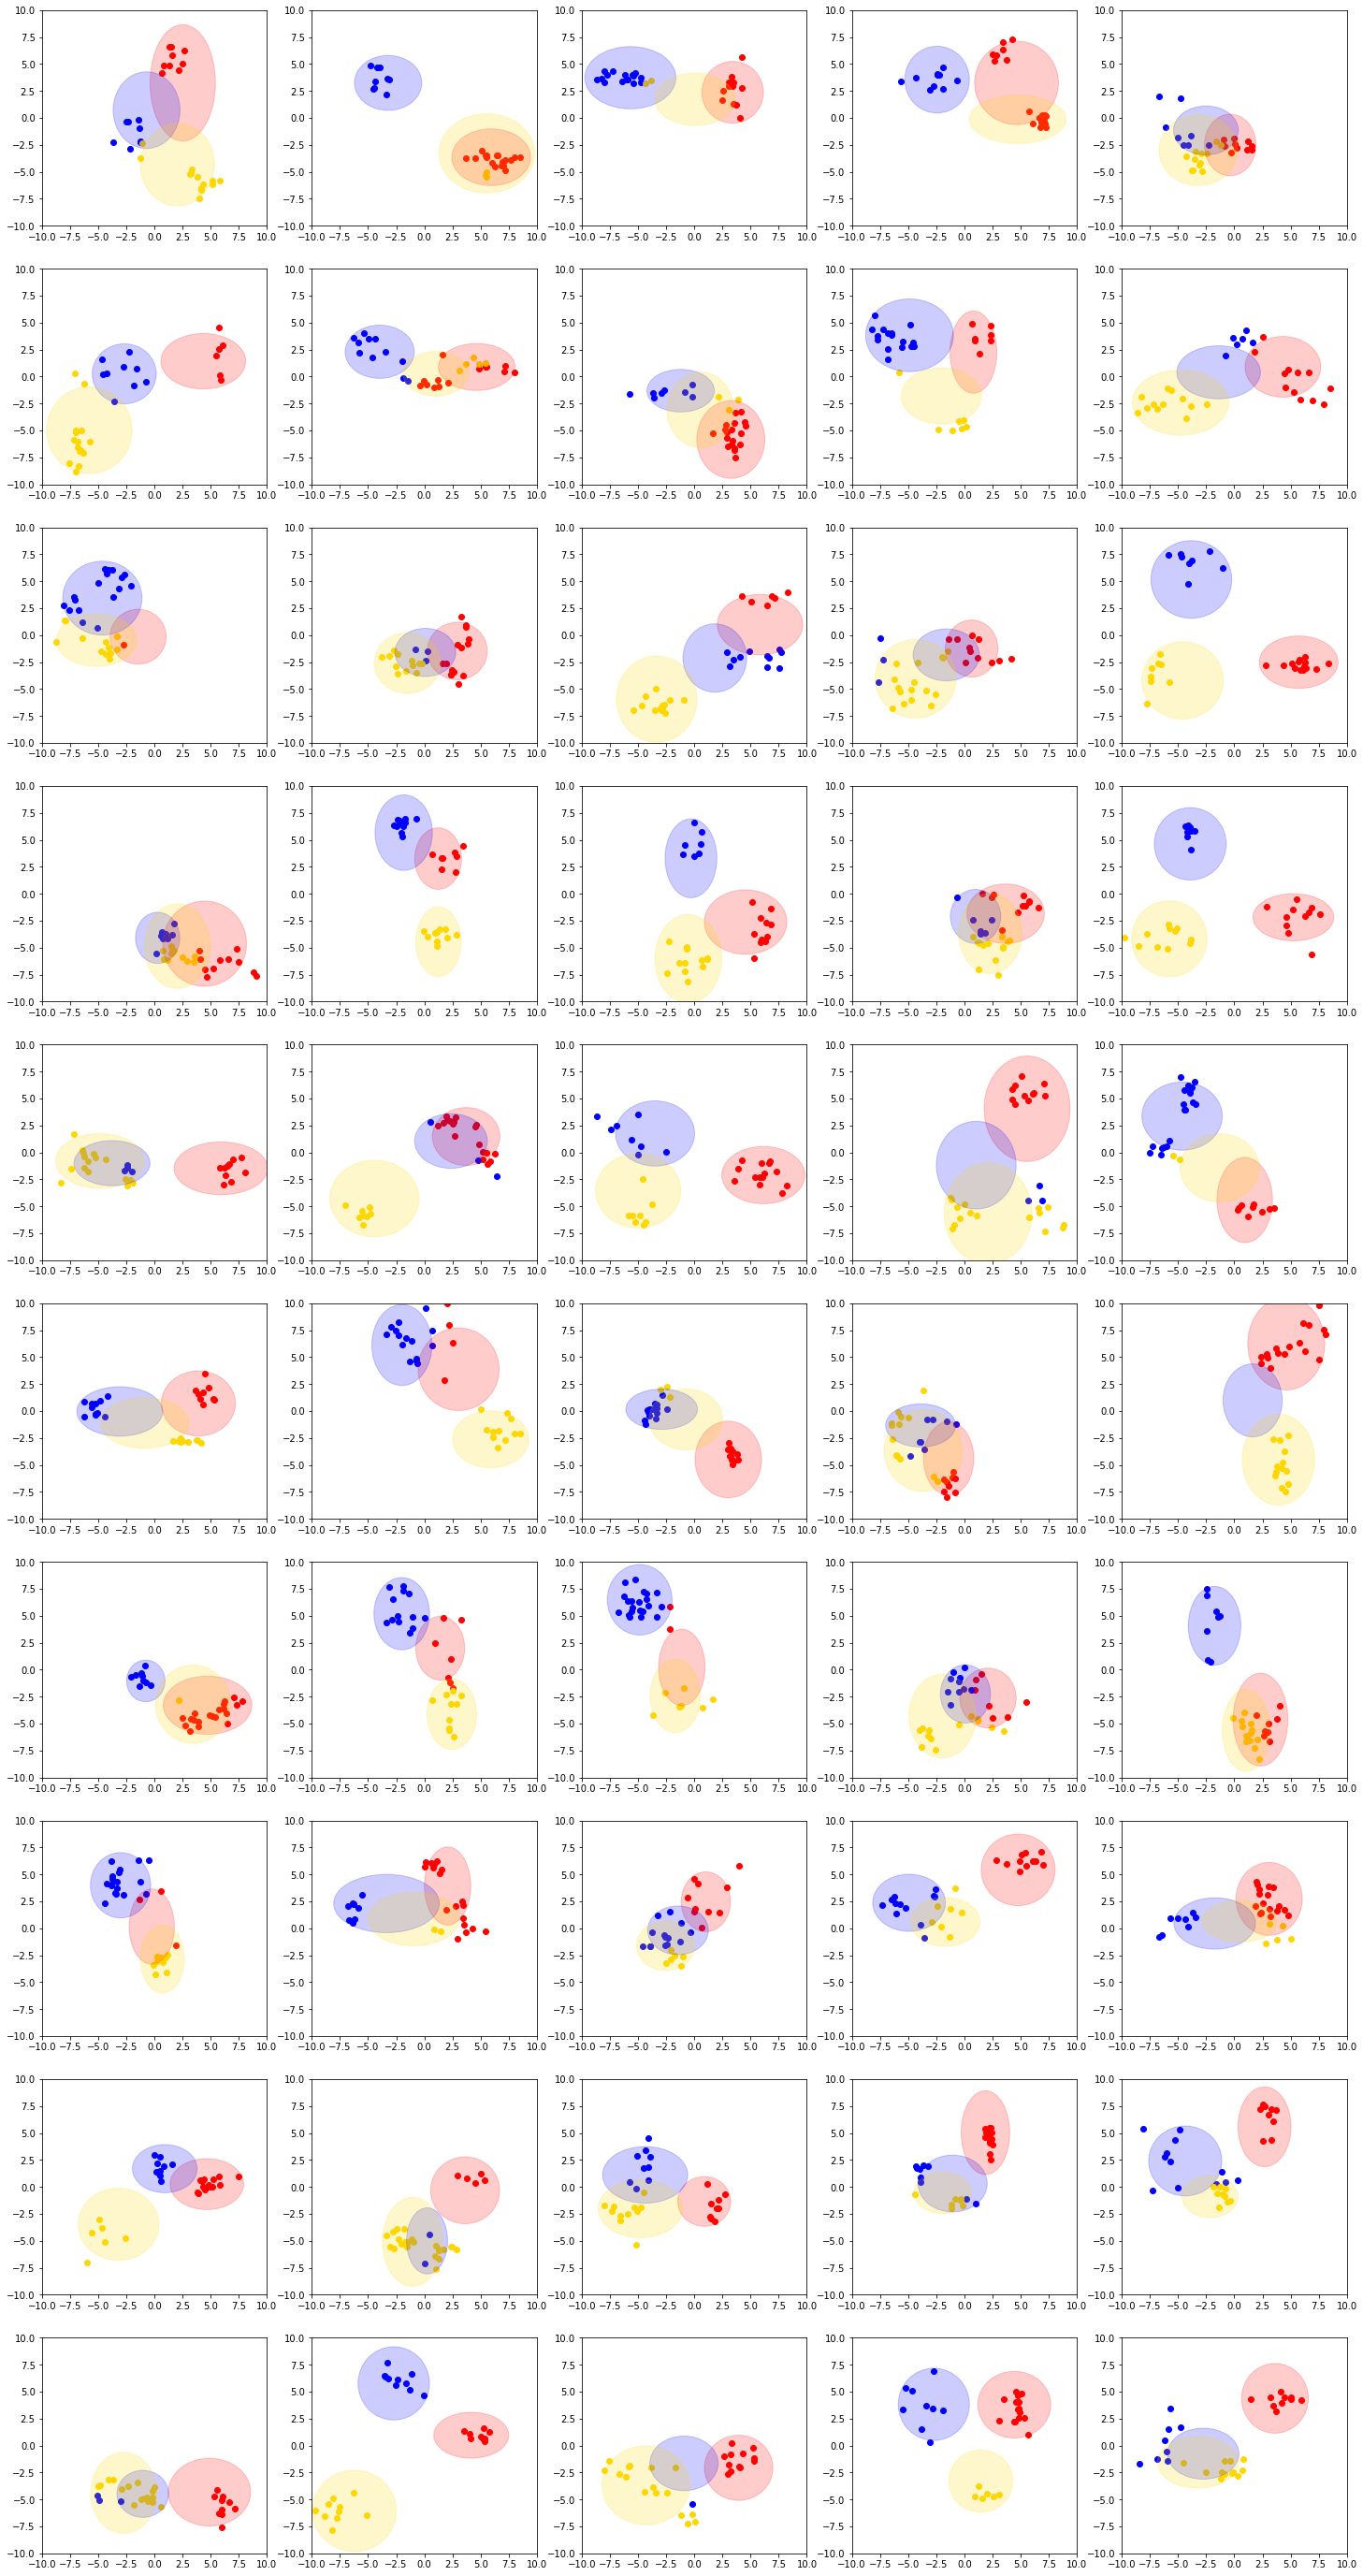

In [17]:
plot_final_samples(x, E_z, E_mus, E_precisions, STEPS, BATCH_SIZE)

In [ ]:
plt.plot(LLS[:15])

In [ ]:
plt.plot(LLS)

In [ ]:
plt.plot(LLS[:80])

In [ ]:
E_mus.shape